# Testing Black-Scholes implementation

Here, we simply look at some real data and check if our implementation of the Black-Scholes option pricing is correct.

In [1]:
from datetime import datetime

import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import yfinance as yf

from quant_learn.options.black_scholes import black_scholes_value

First, we need a way to compute the risk-free interest rate. It appears to me `yfinance` does not keep track of all different Treasury bills (from 4 weeks to 1 year), notes (2 to 5 years), and bonds (10+ years). They seem to have the 13-week T-bill `^IRX`, and others that are 5+ years (`^FVX` for 5, `^TNX` for 10, and `^TYX` for 30 years). We will most likely use the 13-week T-bill, but let's keep the others just in case. We will keep a list containing the tickers on `yfinance`, and another with the relevant periods of time, in days.

In [2]:
treasury_tickers = ['^IRX', '^FVX', '^TNX', '^TYX']
treasury_terms_days = [91, 1825, 3650, 10950]

Let's look at options for some reputable stocks: Microsoft

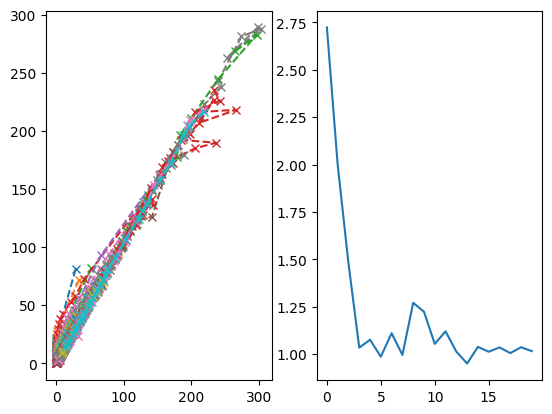

In [18]:
tickers = ['MSFT']

# Generate figure
fig, axes = plt.subplots(len(tickers), 2)

for i, symbol in enumerate(tickers):
    ticker_all = yf.Ticker(ticker=symbol)

    # Let's initialize an array to collect the fits of expected price vs. actual price
    fits = []

    # Collect expiration dates
    expiration_dates = ticker_all.options
    for exp_date_str in expiration_dates[:]:  # [4:5]:  # 
        # Compute relevant interest rate
        exp_date = datetime.strptime(exp_date_str, '%Y-%m-%d')
        # Compute time to maturity
        tau = int((exp_date - datetime.today()).days)
        if tau == 0:  # skip those expiring today
            continue
        # Get appropriate ticker
        pos = np.searchsorted(treasury_terms_days, tau, side='left')
        t_ticker = treasury_tickers[pos]
        # Get APY
        apy = yf.Ticker(ticker=t_ticker).history(period='1d')['Close'].values.item() / 100.  # they are reported in %
        r = np.pow((1. + apy), (1./365)) - 1.

        # Now, let's get the calls and puts for the expiration date
        options = {'call': ticker_all.option_chain(date=exp_date_str).calls,
                   'put': ticker_all.option_chain(date=exp_date_str).puts}

        for style, data in options.items():
            # For call options with underlying stocks that pay no dividends, the theoretical price of the American
            # option is the same as for the European option. However, that is not the case for put options, so we will
            # skip those, and only look at the call options
            if style == 'put':
                continue
            
            # Clean up the data to only look at cases where there is interest in the options
            data = data[data['openInterest'] >= 100]
            
            implied_vol = data['impliedVolatility'].to_numpy()
            strike = data['strike'].to_numpy()
            spot = data['lastPrice'].to_numpy()
            value = (data['bid'].to_numpy() + data['ask'].to_numpy()) / 2.
            expected_values = black_scholes_value(strike_price=strike,
                                                  spot_price=spot,
                                                  time_to_maturity=tau,
                                                  interest_rate=r,
                                                  volatility=implied_vol)
            expected_value = expected_values[style]                                      
            # expected_value = np.where(expected_values[style] < 0, 0., expected_values[style])
            axes[0].plot(expected_value, value, '--', marker='x')

            # Let's also check how good the match is
            fit = linregress(x=expected_value, y=value)
            fits += [fit]
    
    # Now, plot the fits
    axes[1].plot([result.slope for result in fits])

In [17]:
[result.slope for result in fits]

[np.float64(1.0164544244687688)]

In [5]:
options['put']

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,MSFT271217P00195000,2025-03-21 19:38:55+00:00,195.0,4.35,3.50,4.60,-0.650000,-13.000003,153,688,0.295417,False,REGULAR,USD
1,MSFT271217P00200000,2025-03-18 18:06:52+00:00,200.0,4.70,2.50,6.50,0.000000,0.000000,1,8,0.312782,False,REGULAR,USD
2,MSFT271217P00210000,2025-03-19 16:45:34+00:00,210.0,5.60,4.05,7.90,0.000000,0.000000,10,435,0.310386,False,REGULAR,USD
3,MSFT271217P00220000,2025-03-21 13:57:08+00:00,220.0,7.14,4.60,8.75,-0.360000,-4.800002,100,453,0.300514,False,REGULAR,USD
4,MSFT271217P00230000,2025-03-14 17:24:11+00:00,230.0,10.55,5.25,10.00,0.000000,0.000000,1,126,0.294105,False,REGULAR,USD
5,MSFT271217P00240000,2025-03-14 14:42:50+00:00,240.0,11.23,7.00,11.45,0.000000,0.000000,1,37,0.288505,False,REGULAR,USD
6,MSFT271217P00250000,2025-03-20 16:51:01+00:00,250.0,10.95,8.00,12.40,0.150000,1.388885,1,138,0.277977,False,REGULAR,USD
7,MSFT271217P00260000,2025-03-21 14:12:03+00:00,260.0,12.25,9.85,13.80,-0.150000,-1.209674,2,30,0.270530,False,REGULAR,USD
8,MSFT271217P00270000,2025-03-20 14:02:09+00:00,270.0,12.50,11.10,15.80,0.000000,0.000000,5,82,0.266548,False,REGULAR,USD
9,MSFT271217P00280000,2025-03-21 19:27:17+00:00,280.0,16.66,13.20,17.80,0.660000,4.124999,2,86,0.261436,False,REGULAR,USD


In [ ]:
symbol = 'MSFT'
ticker = yf.Ticker(ticker=symbol)
expiration = ticker.options
expiration

In [ ]:
yf.Ticker(ticker=treasury_tickers[0]).history(period='1d')['Close'].values

In [ ]:
yf.Ticker(ticker='MSFT').history(period='1d')